In [97]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle
import pandas
import re
from pathlib import Path
import numpy as np
import random
import os

import Utilities

In [16]:
csv_categorized = Utilities.GetCSVDictionary()

CP1 - 314 
CP8 - 282 
CP7 - 301 
CP3 - 309 
CP2 - 302 
CP5 - 305 
CP6 - 281 
CP4 - 3 


In [23]:
scenarioNumber='1'
CombinedRender = [   #CP1
"ISR02",
"ISR03",
"ISR05",
"ISR08",
"ISR09",
"ISR10",
"ISR12",
"ISR14",
"ISR16",
"ISR18",
"ISR19",
"ISR21",
"ISR22",
"ISR23",
"ISR24",
"ISR25",
"ISR26",
"ISR28",
"ISR29",
"ISR30",
"ISR31",
"ISR32",
"ISR33",
"ISR34",
"ISR35",
"ISR36",
"ISR37",
"ISR38",
"ISR39",
"ISR41",
"ISR42",
"NYC10",
"NYC11",
"NYC13",
"NYC16",
"NYC17",
"NYC18",
"NYC19",
"NYC20",
"NYC21",
"NYC22",
"NYC23",
"NYC24",
"NYC25",
"NYC26",
"NYC27",
"NYC28",
"NYC29",
"NYC32",
"NYC35",
"NYC36",
"NYC37",
"NYC38",
"NYC39",
"NYC40",
"NYC41",
"NYC42",
"NYC41",
"NYC42",
"NYC41",
"NYC42"
]

KeyboardInterrupt: 

In [32]:

renderdict={}
for scen in csv_categorized[scenarioNumber]:
    Name = scen.name
    pair =Name.split('_')[1].split('-')[1]
    if(pair in CombinedRender):
        renderdict[pair]=scen
a= [x for x in renderdict.keys() if x not in CombinedRender]   
if(len(a)>0):
    print("we are missing a file",a)
else:
    print("we got all files")

    

we got all files


In [39]:
cwd = os.getcwd()
video_out = Path(cwd) / 'VideoPath'

In [129]:

def DrawAnimationVideo(path,name,outputPath):   
    wantedDistanceWithin = 35
    df = pandas.read_csv(path, sep=';')
    dfLimit = df[\
         ((df['HeadPosXA'] > -wantedDistanceWithin) & (df['HeadPosXA'] < wantedDistanceWithin)) \
            & ((df['HeadPosZA'] > -wantedDistanceWithin) & (df['HeadPosZA'] < wantedDistanceWithin))\
            & ((df['HeadPosXB'] > -wantedDistanceWithin) & (df['HeadPosXB'] < wantedDistanceWithin)) \
            & ((df['HeadPosZB'] > -wantedDistanceWithin) & (df['HeadPosZB'] < wantedDistanceWithin))]
    #print(df.columns)
   
    frameCount = len(dfLimit)
    length= dfLimit["ScenarioTime"].iloc[-1] - dfLimit["ScenarioTime"].iloc[0]
    frameTime = length/frameCount
    #print(f"FrameTime:{frameTime}, frameCount:{frameCount}, length:{length}")
    

    fig, ax = plt.subplots()
    fig.set_size_inches(8, 8, True)
    ax.set_title=name
    ax.axis('equal')
    ax.set(xlim=[-wantedDistanceWithin, wantedDistanceWithin], ylim=[-wantedDistanceWithin, wantedDistanceWithin], xlabel='x', ylabel='y')
   
    scatA = ax.scatter(dfLimit['HeadPosXA'].iloc[0], dfLimit['HeadPosZA'].iloc[0], c="r", s=5, label=f'A')
    scatB = ax.scatter(dfLimit['HeadPosXB'].iloc[0], dfLimit['HeadPosZB'].iloc[0], c="b", s=5, label=f'B')
    txt = ax.text(0,37,f"{name} : {dfLimit["ScenarioTime"].iloc[0]:.1f}",fontsize=14,horizontalalignment='center',verticalalignment='center')
    
    rect = ax.add_patch(Rectangle((dfLimit['HeadPosXA'].iloc[0], dfLimit['HeadPosZA'].iloc[0]),2,3.6,angle=-dfLimit['HeadrotYA'].iloc[0],rotation_point='xy'))
    rect.set_color('r')
    ax.legend()
    def update(frame):
        # update the scatter plot:
        dataA = np.stack([dfLimit['HeadPosXA'].iloc[frame], dfLimit['HeadPosZA'].iloc[frame]]).T
        scatA.set_offsets(dataA)

        dataB = np.stack([dfLimit['HeadPosXB'].iloc[frame], dfLimit['HeadPosZB'].iloc[frame]]).T
        scatB.set_offsets(dataB)
        txt.set_text(f"{name} : {dfLimit["ScenarioTime"].iloc[frame]:.1f}")

        rect.set_xy(dataA)
        rect.set_angle(-dfLimit['HeadrotYA'].iloc[frame])
        return (scatA,scatB,txt,rect)

    ani = animation.FuncAnimation(fig=fig, func=update, frames=frameCount, interval=1000*frameTime)
    ani.save(filename=outputPath, writer="ffmpeg",dpi=100)

Index(['AccelA', 'AccelB', 'ButtonA', 'ButtonB', 'Car PositionXA',
       'Car PositionXB', 'Car PositionYA', 'Car PositionYB', 'Car PositionZA',
       'Car PositionZB', 'Car RotationXA', 'Car RotationXB', 'Car RotationYA',
       'Car RotationYB', 'Car RotationZA', 'Car RotationZB', 'Car VelocityXB',
       'Car VelocityYA', 'Car VelocityYB', 'Car VelocityZA', 'Car VelocityZB',
       'CarVelocityXA', 'Frame Number', 'FrameRate', 'GameTime', 'HeadPosXA',
       'HeadPosXB', 'HeadPosYA', 'HeadPosYB', 'HeadPosZA', 'HeadPosZB',
       'HeadrotXA', 'HeadrotXB', 'HeadrotYA', 'HeadrotYB', 'HeadrotZA',
       'HeadrotZB', 'IndicatorsA', 'IndicatorsB', 'LeftHandA', 'LeftHandB',
       'RightHandA', 'RightHandB', 'ScenarioTime', 'SteerA', 'SteerB'],
      dtype='object')
FrameTime:0.07016582733812951, frameCount:278, length:19.506100000000004


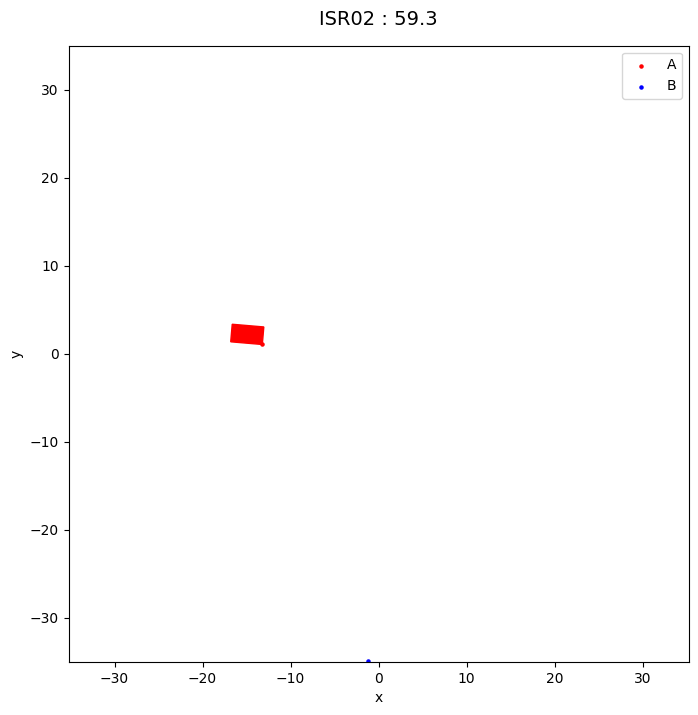

In [130]:
DrawAnimationVideo(renderdict["ISR02"],"ISR02",video_out / "scenario{1}-ISR02.mp4")